# Matrix Profile Example
## 2018 NYC Yellow Taxi Passengers

In this example, we use the MPX algorithm to perform both data mining and exploratory analysis tasks. MPX is an exact algorithm; meaning that it will not give an approximate solution. The data set is composed of aggregated passenger counts for yellow taxi cabs in NYC during the year 2018. If you are interested in learning more about the original data, please refer to the "NYC Taxi 2018 Aggregation" notebook.

Note that MPX is the default "compute" algorithm for exact computation.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import matrixprofile as mp

%matplotlib inline

# Load Data

Here we load in the aggregated data and make sure that the datetime is the correct data type and set as the index.

In [2]:
df = pd.read_csv('data/nyc_yellow_taxi_passenger_count_2018_hourly.csv')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df = df.set_index('pickup_datetime').sort_index()

# Data Sample and Descriptive Stats

In [3]:
df.head()

,passenger_count
pickup_datetime,
2018-01-01 00:00:00,28630
2018-01-01 01:00:00,32778
2018-01-01 02:00:00,27966
2018-01-01 03:00:00,21243
2018-01-01 04:00:00,14822


Here we see a minimum passenger count of 3. Interesting...

In [4]:
df['passenger_count'].describe()

count     8760.000000
mean     18716.562671
std       8961.120977
min          3.000000
25%      11464.500000
50%      21502.500000
75%      25180.500000
max      38420.000000
Name: passenger_count, dtype: float64

# Visualize Raw Data

Visualizing the raw data shows that you can see some trends around certain periods. However, imagine if the plot was smaller or there were many more data points. It would become very cumbersome to perform this analysis manually.

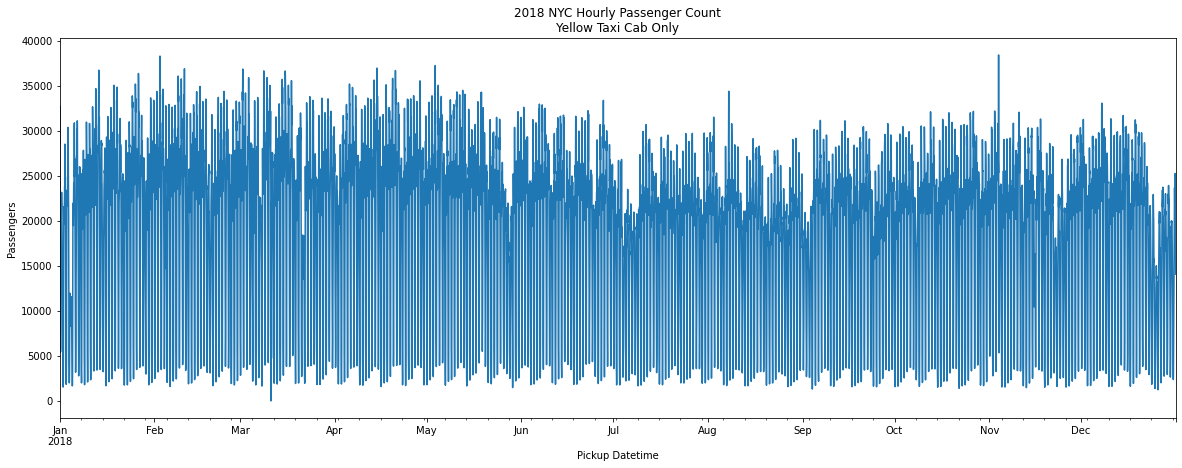

In [5]:
df.plot(figsize=(20,7), legend=None, title='2018 NYC Hourly Passenger Count\nYellow Taxi Cab Only')
plt.xlabel('Pickup Datetime')
plt.ylabel('Passengers')
plt.show()

# Compute Matrix Profiles

Here we compute Matrix Profiles over varying window sizes:

* 4 hours
* 8 hours
* 12 hours (Half of a day)
* 24 hours (A day)
* 168 hours (7 days)
* 720 hours (30 days)

In [26]:
windows = [
    ('4 Hours', 4),
    ('8 Hours', 8),
    ('12 Hours', 12),
    ('24 Hours', 24),
    ('7 Days', 7 * 24),
    ('30 Days', 30 * 24),
]

profiles = {}

for label, window_size in windows:
    profile = mp.compute(df['passenger_count'].values, window_size)
    key = '{} Profile'.format(label)
    profiles[key] = profile

# Plot Matrix Profiles

Below is a plot showing the different Matrix Profiles over the window sizes described above. Notice that the window size chosen drastically changes the Matrix Profile that is computed. When analyzing your data, it is important to choose appropriate window sizes to answer your desired questions.

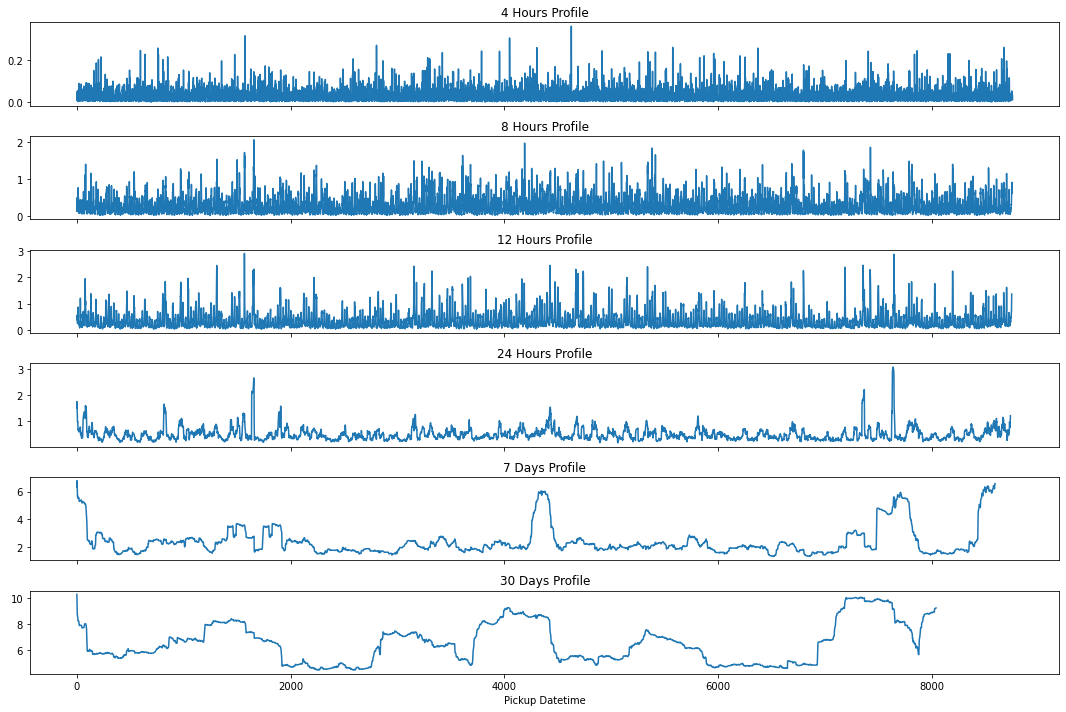

In [27]:
#Plot the signal data
fig, axes = plt.subplots(6,1,sharex=True,figsize=(15,10))

for ax_idx, window in enumerate(windows):
    key = '{} Profile'.format(window[0])
    profile = profiles[key]
    axes[ax_idx].plot(profile['mp'])
    axes[ax_idx].set_title(key)

plt.xlabel('Pickup Datetime')
plt.tight_layout()
plt.show()

# Find Discords

Here we find the top 5 anomalies for each window. An exclusion zone is required to avoid matching on time periods that are very close to one another.

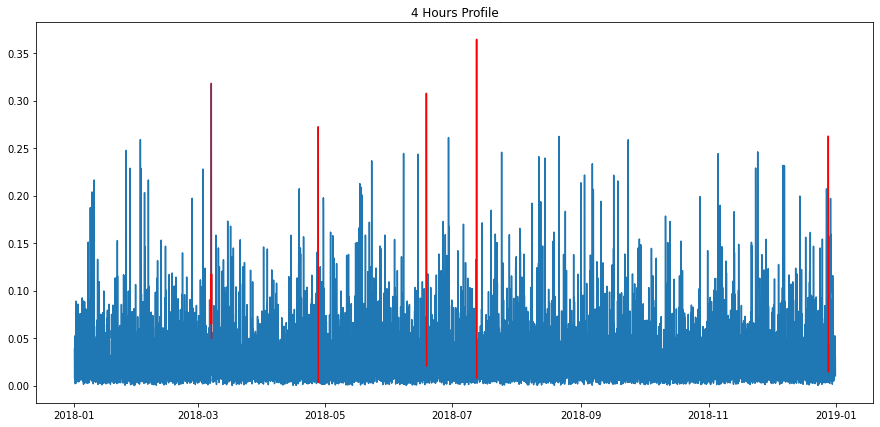

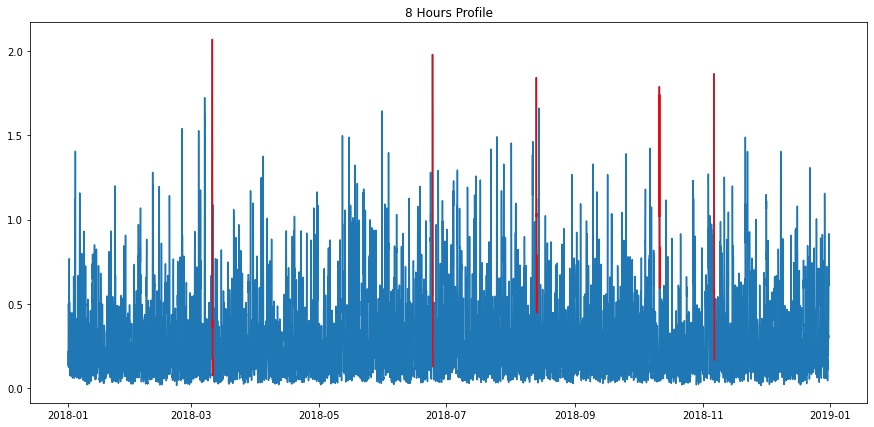

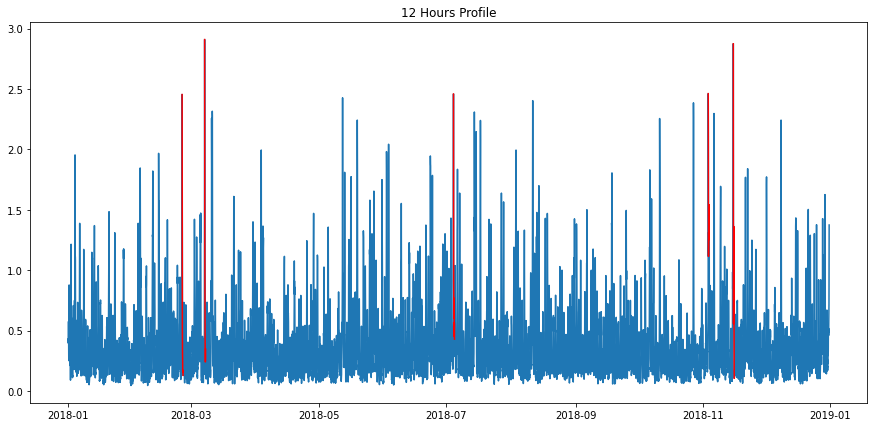

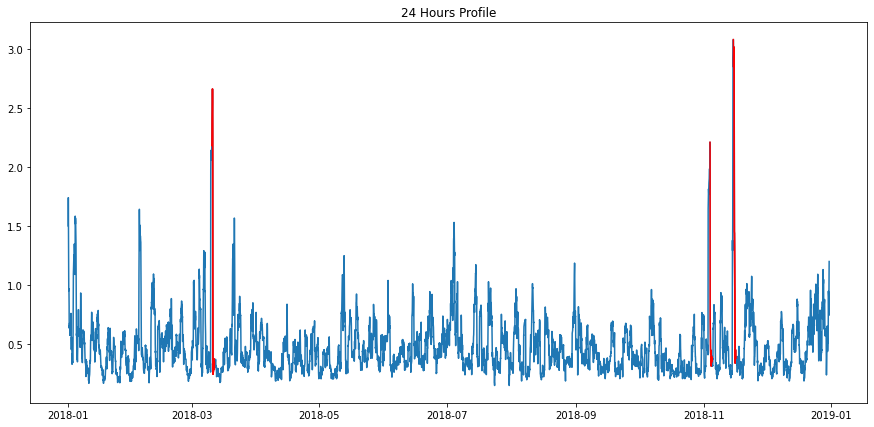

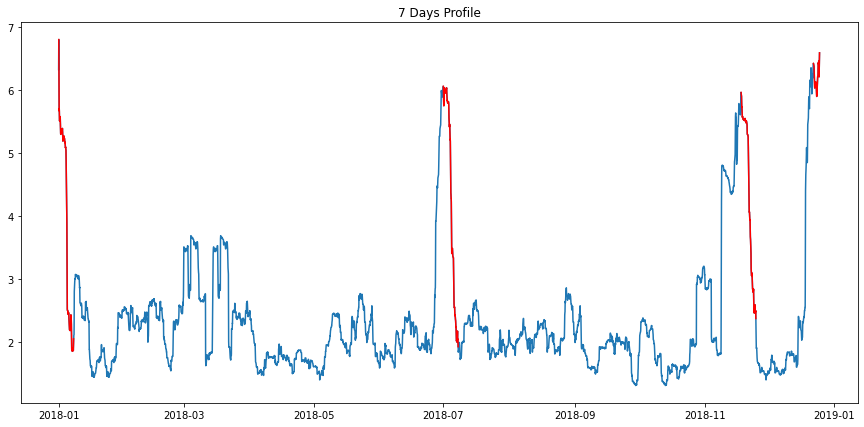

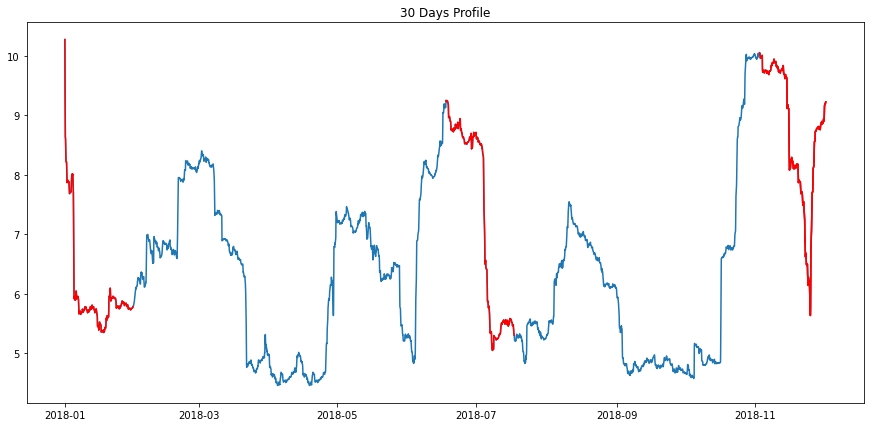

In [28]:
for label, window_size in windows:
    key = '{} Profile'.format(label)
    profiles[key] = mp.discover.discords(profiles[key], k=5)
    
    window_size = profiles[key]['w']
    mp_adjusted = np.append(profiles[key]['mp'], np.zeros(window_size - 1) + np.nan)
    
    plt.figure(figsize=(15, 7))
    ax = plt.plot(df.index.values, mp_adjusted)
    plt.title(key)
    
    for start_index in profiles[key]['discords']:
        x = df.index.values[start_index:start_index+window_size]
        y = mp_adjusted[start_index:start_index+window_size]
        plt.plot(x, y, c='r')
    
    plt.show()

# 24 Hour Discords

Here we do a little bit of Googling to figure out why these are potential top discords.

In [38]:
key = '24 Hours Profile'
profile = profiles[key]
window_size = profile['w']
mp_adjusted = np.append(profile['mp'], np.zeros(window_size - 1) + np.nan)
df['24 Hours Profile'] = mp_adjusted

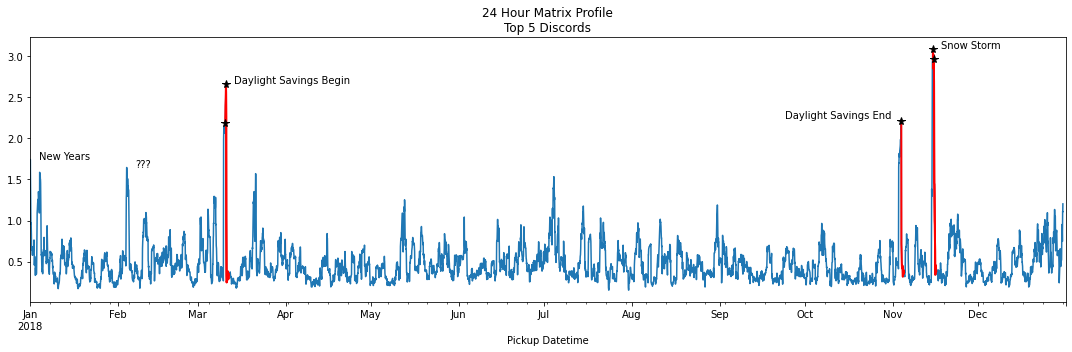

In [41]:
ax = df[key].plot(title='24 Hour Matrix Profile\nTop 5 Discords', figsize=(15,5))

for discord in profile['discords']:
    df.iloc[discord:discord+window_size][key].plot(ax=ax, c='r', lw='2')

df.iloc[profile['discords']][key].plot(kind='line', marker='*', c='black', markersize=8, ax=ax, lw=0)
plt.text('01-04-2018', 1.75, 'New Years', c='black')
plt.text('02-07-2018', 1.65, '???', c='black')
plt.text('03-14-2018', 2.675, 'Daylight Savings Begin', c='black')
plt.text('9-24-2018', 2.25, 'Daylight Savings End', c='black')
plt.text('11-18-2018', 3.1, 'Snow Storm', c='black')
plt.xlabel('Pickup Datetime')
plt.tight_layout()
plt.show()

# 7 Day Discords

Here we do a little bit of Googling to figure out why these are potential top discords.

In [42]:
key = '7 Days Profile'
profile = profiles[key]
window_size = profile['w']
mp_adjusted = np.append(profile['mp'], np.zeros(window_size - 1) + np.nan)
df[key] = mp_adjusted

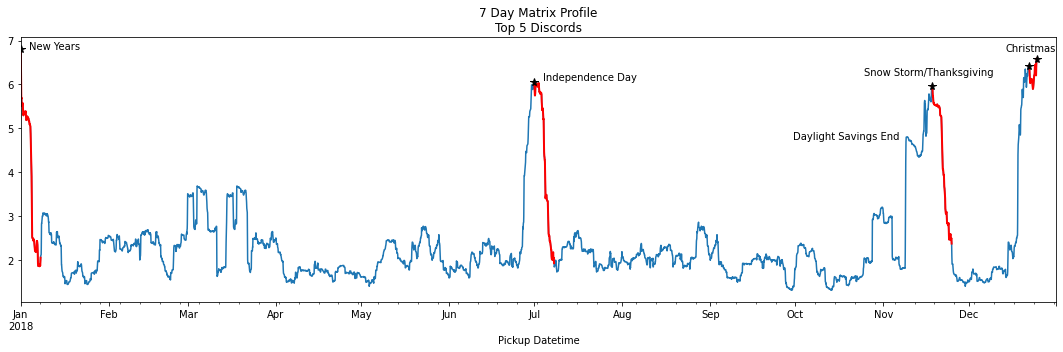

In [44]:
ax = df[key].plot(title='7 Day Matrix Profile\nTop 5 Discords', figsize=(15,5))

for discord in profile['discords']:
    df.iloc[discord:discord+window_size][key].plot(ax=ax, c='r', lw='2')

df.iloc[profile['discords']][key].plot(kind='line', marker='*', c='black', markersize=8, ax=ax, lw=0)
plt.text('01-04-2018', 6.8, 'New Years', c='black')
plt.text('07-04-2018', 6.1, 'Independence Day', c='black')
plt.text('9-30-2018', 4.75, 'Daylight Savings End', c='black')
plt.text('10-25-2018', 6.2, 'Snow Storm/Thanksgiving', c='black')
plt.text('12-14-2018', 6.75, 'Christmas', c='black')
plt.xlabel('Pickup Datetime')
plt.tight_layout()
plt.show()